<a href="https://colab.research.google.com/github/patil-yasshh/projects/blob/main/Salaries_for_San_Francisco_Employee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading data from: /content/Total.csv


/tmp/ipython-input-3226043174.py:21: DtypeWarning: Columns (2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Shape: (312882, 9)
Target columns found: ['BasePay', 'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits']

Descriptive statistics (selected columns):
                     count           mean     median           std       min  \
BasePay           130466.0   72329.186734   71644.57  43392.247439   -166.01   
OvertimePay        65535.0    5539.646113      94.88  12041.815552      0.00   
OtherPay           65535.0    2918.779005     735.20   5937.194998    -60.00   
Benefits           94912.0   27769.332609   29170.69  12369.055344 -13939.42   
TotalPay          312882.0   78802.645788   74908.79  53230.758542   -618.13   
TotalPayBenefits  312882.0  100928.339777  100011.29  66485.186495  -3628.78   

                         25%        50%          75%        max  
BasePay           45625.2600   71644.57   99016.1000  545294.86  
OvertimePay           0.0000      94.88    5569.6400  273076.56  
OtherPay              0.0000     735.20    3268.5550  191685.15  
Benefit

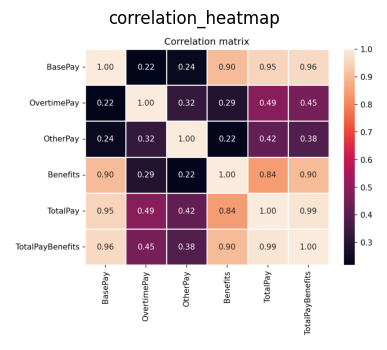

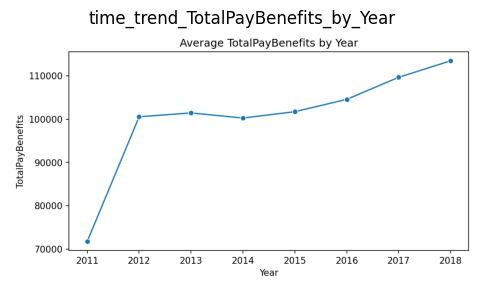

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression

# --- Settings ---
DATA_PATH = "/content/Total.csv"
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)
PLOT_DPI = 150
TARGET_COLS = [
    "BasePay", "OvertimePay", "OtherPay", "Benefits", "TotalPay", "TotalPayBenefits"
]

# --- Helpers ---
def load_data(path):
    print(f"Loading data from: {path}")
    df = pd.read_csv(path)
    print(f"Shape: {df.shape}")
    return df

def clean_money_column(series):
    """Convert a money column to numeric: remove commas, $ signs; coerce errors to NaN."""
    if series.dtype == object:
        s = series.str.replace(r'[\$,]', '', regex=True).str.strip()
        return pd.to_numeric(s, errors='coerce')
    else:
        return pd.to_numeric(series, errors='coerce')

def ensure_columns(df, cols):
    """Return list of cols actually present in df (case-insensitive mapping)."""
    col_map = {c.lower(): c for c in df.columns}
    present = []
    for c in cols:
        if c in df.columns:
            present.append(c)
        elif c.lower() in col_map:
            present.append(col_map[c.lower()])
    return present

def summary_statistics(df, cols):
    stats = df[cols].describe().T
    stats["median"] = df[cols].median()
    stats = stats[["count", "mean", "median", "std", "min", "25%", "50%", "75%", "max"]]
    return stats

def safe_plot_save(fig, name):
    path = FIG_DIR / name
    fig.savefig(path, dpi=PLOT_DPI, bbox_inches="tight")
    print(f"Saved plot: {path}")

# --- Main EDA functions ---
def basic_cleaning(df):
    df.columns = [c.strip() for c in df.columns]
    present = ensure_columns(df, TARGET_COLS)
    print(f"Target columns found: {present}")
    for col in present:
        df[col] = clean_money_column(df[col])
    return df, present

def analyze_missing(df, cols):
    miss = df[cols].isna().sum().sort_values(ascending=False)
    pct = (miss / len(df) * 100).round(2)
    missing_df = pd.concat([miss, pct], axis=1)
    missing_df.columns = ["missing_count", "missing_pct"]
    print("\nMissing values (by column):")
    print(missing_df)
    return missing_df

def correlation_and_heatmap(df, cols):
    corr = df[cols].corr()
    print("\nCorrelation matrix:")
    print(corr)
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, ax=ax)
    ax.set_title("Correlation matrix")
    safe_plot_save(fig, "correlation_heatmap.png")
    plt.close(fig)
    return corr

def histograms(df, cols):
    for col in cols:
        fig, ax = plt.subplots(figsize=(6,4))
        sns.histplot(df[col].dropna(), kde=True, ax=ax)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Count")
        safe_plot_save(fig, f"hist_{col}.png")
        plt.close(fig)

def boxplots(df, cols):
    for col in cols:
        fig, ax = plt.subplots(figsize=(6,4))
        sns.boxplot(x=df[col].dropna(), ax=ax)
        ax.set_title(f"Boxplot of {col}")
        safe_plot_save(fig, f"box_{col}.png")
        plt.close(fig)

def scatter_with_regression(df, x_col, y_col):
    xy = df[[x_col, y_col]].dropna()
    if xy.empty:
        print(f"No data for scatter {x_col} vs {y_col}")
        return
    X = xy[[x_col]].values
    y = xy[y_col].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = model.score(X, y)
    fig, ax = plt.subplots(figsize=(6,5))
    sns.scatterplot(x=x_col, y=y_col, data=xy, ax=ax, alpha=0.6)
    ax.plot(X.flatten(), y_pred, color="red", label=f"Linear fit (R²={r2:.2f})")
    ax.legend()
    ax.set_title(f"{y_col} vs {x_col}")
    safe_plot_save(fig, f"scatter_{x_col}_vs_{y_col}.png")
    plt.close(fig)
    print(f"Scatter {x_col} vs {y_col} saved (R^2={r2:.3f})")

def top_jobs_or_departments(df, top_n=15):
    candidates = ["JobTitle", "Job Title", "Title", "Department"]
    found = None
    for c in candidates:
        if c in df.columns:
            found = c
            break
    if not found:
        print("No job/title/department column detected (skipping top jobs analysis).")
        return None
    counts = df[found].value_counts().head(top_n)
    fig, ax = plt.subplots(figsize=(8, max(4, top_n*0.3)))
    sns.barplot(x=counts.values, y=counts.index, ax=ax)
    ax.set_xlabel("Count")
    ax.set_ylabel(found)
    ax.set_title(f"Top {top_n} {found}s by frequency")
    safe_plot_save(fig, f"top_{found.replace(' ', '_')}.png")
    plt.close(fig)
    return counts

def contribution_analysis(df, present):
    target_tp = "TotalPay" if "TotalPay" in present else "TotalPayBenefits" if "TotalPayBenefits" in present else None
    if not target_tp:
        print("No TotalPay or TotalPayBenefits found to perform contribution analysis.")
        return
    components = [c for c in ["BasePay", "OvertimePay", "OtherPay", "Benefits"] if c in present]
    mean_vals = df[components + [target_tp]].dropna().mean()
    contributions = {c: (mean_vals[c] / mean_vals[target_tp]) if mean_vals[target_tp] != 0 else np.nan for c in components}
    print(f"\nAverage proportional contributions to {target_tp}:")
    for c, v in contributions.items():
        print(f"  {c}: {v:.2%}" if not pd.isna(v) else f"  {c}: NaN")
    fig, ax = plt.subplots(figsize=(6,6))
    comp_vals = [mean_vals[c] for c in components]
    ax.pie(comp_vals, labels=components, autopct="%1.1f%%", startangle=140)
    ax.set_title(f"Average share of components (mean amounts) — vs {target_tp}")
    safe_plot_save(fig, f"component_shares_{target_tp}.png")
    plt.close(fig)
    return contributions

def time_trend_analysis(df):
    year_col = None
    for c in df.columns:
        if c.lower() == "year":
            year_col = c
            break
    if not year_col:
        print("No 'Year' column found — skipping time trend analysis.")
        return
    value_col = "TotalPayBenefits" if "TotalPayBenefits" in df.columns else "TotalPay" if "TotalPay" in df.columns else None
    if not value_col:
        print("No TotalPay/TotalPayBenefits for time trend.")
        return
    trend = df.groupby(year_col)[value_col].mean().reset_index()
    fig, ax = plt.subplots(figsize=(8,4))
    sns.lineplot(data=trend, x=year_col, y=value_col, marker="o", ax=ax)
    ax.set_title(f"Average {value_col} by {year_col}")
    ax.set_ylabel(value_col)
    safe_plot_save(fig, f"time_trend_{value_col}_by_{year_col}.png")
    plt.close(fig)
    return trend

# --- Run EDA ---
def run_all(path=DATA_PATH):
    df = load_data(path)
    df, present = basic_cleaning(df)
    if not present:
        print("No target numeric columns found — check column names in the CSV.")
        return
    stats = summary_statistics(df, present)
    print("\nDescriptive statistics (selected columns):")
    print(stats)
    missing = analyze_missing(df, present)
    corr = correlation_and_heatmap(df, present)
    histograms(df, present)
    boxplots(df, present)
    total_col = next((t for t in ["TotalPayBenefits", "TotalPay"] if t in present), None)
    if total_col:
        for comp in present:
            if comp != total_col:
                scatter_with_regression(df, comp, total_col)
    top_counts = top_jobs_or_departments(df)
    contributions = contribution_analysis(df, present)
    trend = time_trend_analysis(df)
    stats.to_csv("summary_statistics_selected_columns.csv")
    missing.to_csv("missing_summary_selected_columns.csv")
    if isinstance(corr, pd.DataFrame):
        corr.to_csv("correlation_matrix_selected_columns.csv")
    print("\nAll done. Figures saved in the 'figures/' folder. Summary CSVs saved in current directory.")
    return df, present

# --- Execute main analysis ---
if __name__ == "__main__":
    df, present = run_all(DATA_PATH)

    # --- NEW SECTION: SHOW KEY PLOTS INLINE ---
    import matplotlib.image as mpimg
    plot_list = [
        "correlation_heatmap.png",
        "component_shares_TotalPayBenefits.png",
        "time_trend_TotalPayBenefits_by_Year.png"
    ]

    # Display main summary plots
    for plot_name in plot_list:
        path = FIG_DIR / plot_name
        if path.exists():
            img = mpimg.imread(path)
            plt.figure(figsize=(6,4))
            plt.imshow(img)
            plt.axis("off")
            plt.title(plot_name.replace(".png", ""))
            plt.show()